In [3]:
%matplotlib inline

In [4]:
import tensorflow as tf
tf.__version__

'2.5.0'


# Object Detection From TF2 Saved Model


This demo will take you through the steps of running an "out-of-the-box" TensorFlow 2 compatible
detection model on a collection of images. More specifically, in this example we will be using
the `Saved Model Format <https://www.tensorflow.org/guide/saved_model>`__ to load the model.



## Download the test images
First we will download the images that we will use throughout this tutorial. The code snippet
shown bellow will download the test images from the `TensorFlow Model Garden <https://github.com/tensorflow/models/tree/master/research/object_detection/test_images>`_
and save them inside the ``data/images`` folder.



In [5]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'    # Suppress TensorFlow logging (1)
import pathlib

tf.get_logger().setLevel('ERROR')           # Suppress TensorFlow logging (2)

# Enable GPU dynamic memory allocation
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

def download_images():
    base_url = 'https://raw.githubusercontent.com/tensorflow/models/master/research/object_detection/test_images/'
    filenames = ['image1.jpg', 'image2.jpg']
    image_paths = []
    for filename in filenames:
        image_path = tf.keras.utils.get_file(fname=filename,
                                            origin=base_url + filename,
                                            untar=False)
        image_path = pathlib.Path(image_path)
        image_paths.append(str(image_path))
    return image_paths

IMAGE_PATHS = download_images()

## Download the model
The code snippet shown below is used to download the pre-trained object detection model we shall
use to perform inference. The particular detection algorithm we will use is the
`CenterNet HourGlass104 1024x1024`. More models can be found in the `TensorFlow 2 Detection Model Zoo <https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md>`_.
To use a different model you will need the URL name of the specific model. This can be done as
follows:

1. Right click on the `Model name` of the model you would like to use;
2. Click on `Copy link address` to copy the download link of the model;
3. Paste the link in a text editor of your choice. You should observe a link similar to ``download.tensorflow.org/models/object_detection/tf2/YYYYYYYY/XXXXXXXXX.tar.gz``;
4. Copy the ``XXXXXXXXX`` part of the link and use it to replace the value of the ``MODEL_NAME`` variable in the code shown below;
5. Copy the ``YYYYYYYY`` part of the link and use it to replace the value of the ``MODEL_DATE`` variable in the code shown below.

For example, the download link for the model used below is: ``download.tensorflow.org/models/object_detection/tf2/20200711/centernet_hg104_1024x1024_coco17_tpu-32.tar.gz``



http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_320x320_coco17_tpu-8.tar.gz

In [6]:
# Download and extract model
def download_model(model_name, model_date):
    base_url = 'http://download.tensorflow.org/models/object_detection/tf2/'
    model_file = model_name + '.tar.gz'
    model_dir = tf.keras.utils.get_file(fname=model_name,
                                        origin=base_url + model_date + '/' + model_file,
                                        untar=True)
    return str(model_dir)

#MODEL_DATE = '20200711'
#MODEL_NAME = 'centernet_hg104_1024x1024_coco17_tpu-32'

MODEL_DATE = '20200711'
MODEL_NAME = 'ssd_mobilenet_v2_320x320_coco17_tpu-8'


PATH_TO_MODEL_DIR = download_model(MODEL_NAME, MODEL_DATE)

## Download the labels
The coode snippet shown below is used to download the labels file (.pbtxt) which contains a list
of strings used to add the correct label to each detection (e.g. person). Since the pre-trained
model we will use has been trained on the COCO dataset, we will need to download the labels file
corresponding to this dataset, named ``mscoco_label_map.pbtxt``. A full list of the labels files
included in the TensorFlow Models Garden can be found `here <https://github.com/tensorflow/models/tree/master/research/object_detection/data>`__.



In [7]:
# Download labels file
def download_labels(filename):
    base_url = 'https://raw.githubusercontent.com/tensorflow/models/master/research/object_detection/data/'
    label_dir = tf.keras.utils.get_file(fname=filename,
                                        origin=base_url + filename,
                                        untar=False)
    label_dir = pathlib.Path(label_dir)
    return str(label_dir)

LABEL_FILENAME = 'mscoco_label_map.pbtxt'
PATH_TO_LABELS = download_labels(LABEL_FILENAME)

## Load the model
Next we load the downloaded model



In [8]:
import time
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils

PATH_TO_SAVED_MODEL = PATH_TO_MODEL_DIR + "/saved_model"
#PATH_TO_SAVED_MODEL = r"C:\Users\Anwesh\.keras\datasets\centernet_mobilenetv2_fpn_od\saved_model"

print('Loading model...', end='')
start_time = time.time()

# Load saved model and build the detection function
detect_fn = tf.saved_model.load(PATH_TO_SAVED_MODEL)

end_time = time.time()
elapsed_time = end_time - start_time
print('Done! Took {} seconds'.format(elapsed_time))

Loading model...Done! Took 39.50693893432617 seconds


## Load label map data (for plotting)
Label maps correspond index numbers to category names, so that when our convolution network
predicts `5`, we know that this corresponds to `airplane`.  Here we use internal utility
functions, but anything that returns a dictionary mapping integers to appropriate string labels
would be fine.



In [9]:
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS,
                                                                    use_display_name=True)

## Putting everything together
The code shown below loads an image, runs it through the detection model and visualizes the
detection results, including the keypoints.

Note that this will take a long time (several minutes) the first time you run this code due to
tf.function's trace-compilation --- on subsequent runs (e.g. on new images), things will be
faster.

Here are some simple things to try out if you are curious:

* Modify some of the input images and see if detection still works. Some simple things to try out here (just uncomment the relevant portions of code) include flipping the image horizontally, or converting to grayscale (note that we still expect the input image to have 3 channels).
* Print out `detections['detection_boxes']` and try to match the box locations to the boxes in the image.  Notice that coordinates are given in normalized form (i.e., in the interval [0, 1]).
* Set ``min_score_thresh`` to other values (between 0 and 1) to allow more detections in or to filter out more detections.



Running inference for C:\Users\Jerish\.keras\datasets\image1.jpg... Running inference for C:\Users\Jerish\.keras\datasets\image2.jpg... 

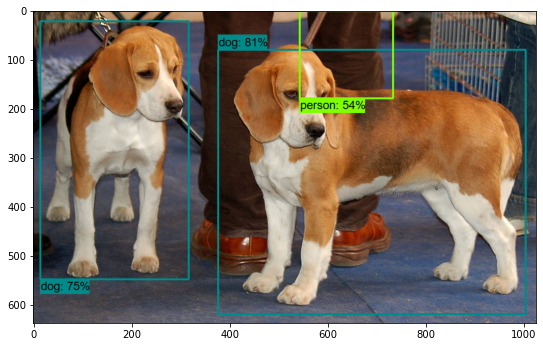

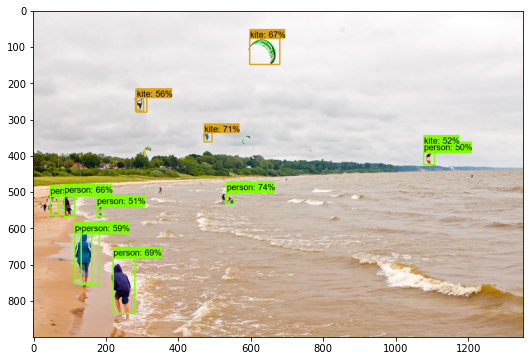

In [10]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')   # Suppress Matplotlib warnings
%matplotlib inline
MATPLOT_IMAGE_DISPLAY_SIZE = [9.0, 6.0]

def load_image_into_numpy_array(path):
    """Load an image from file into a numpy array.

    Puts image into numpy array to feed into tensorflow graph.
    Note that by convention we put it into a numpy array with shape
    (height, width, channels), where channels=3 for RGB.

    Args:
      path: the file path to the image

    Returns:
      uint8 numpy array with shape (img_height, img_width, 3)
    """
    return np.array(Image.open(path))


for image_path in IMAGE_PATHS:

    print('Running inference for {}... '.format(image_path), end='')

    image_np = load_image_into_numpy_array(image_path)

    # Things to try:
    # Flip horizontally
    # image_np = np.fliplr(image_np).copy()

    # Convert image to grayscale
    # image_np = np.tile(
    #     np.mean(image_np, 2, keepdims=True), (1, 1, 3)).astype(np.uint8)

    # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
    input_tensor = tf.convert_to_tensor(image_np)
    # The model expects a batch of images, so add an axis with `tf.newaxis`.
    input_tensor = input_tensor[tf.newaxis, ...]

    # input_tensor = np.expand_dims(image_np, 0)
    detections = detect_fn(input_tensor)

    # All outputs are batches tensors.
    # Convert to numpy arrays, and take index [0] to remove the batch dimension.
    # We're only interested in the first num_detections.
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                   for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
          image_np_with_detections,
          detections['detection_boxes'],
          detections['detection_classes'],
          detections['detection_scores'],
          category_index,
          use_normalized_coordinates=True,
          max_boxes_to_draw=200,
          min_score_thresh=.50,
          agnostic_mode=False)

    plt.figure(figsize=MATPLOT_IMAGE_DISPLAY_SIZE)
    plt.imshow(image_np_with_detections)

plt.show()

# sphinx_gallery_thumbnail_number = 2

In [11]:
import cv2
cap = cv2.VideoCapture('test_video.mp4')
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')   # Suppress Matplotlib warnings
from object_detection.utils import visualization_utils as viz_utils

while True:
    ret, image_np = cap.read()
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    input_tensor = tf.convert_to_tensor(image_np)
    # The model expects a batch of images, so add an axis with `tf.newaxis`.
    input_tensor = input_tensor[tf.newaxis, ...]

    # input_tensor = np.expand_dims(image_np, 0)
    detections = detect_fn(input_tensor)

    # All outputs are batches tensors.
    # Convert to numpy arrays, and take index [0] to remove the batch dimension.
    # We're only interested in the first num_detections.
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                   for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    image_np_with_detections = image_np.copy()
    viz_utils.visualize_boxes_and_labels_on_image_array(
          image_np_with_detections,
          detections['detection_boxes'],
          detections['detection_classes'],
          detections['detection_scores'],
          category_index,
          use_normalized_coordinates=True,
          max_boxes_to_draw=200,
          min_score_thresh=.50,
          agnostic_mode=False)
 
    cv2.imshow('object detection', cv2.resize(image_np_with_detections, (800,600)))
    if cv2.waitKey(25) & 0xFF == ord('q'):
        cv2.destroyAllWindows()
        break

In [12]:
IMAGE_PATHS

['C:\\Users\\Jerish\\.keras\\datasets\\image1.jpg',
 'C:\\Users\\Jerish\\.keras\\datasets\\image2.jpg']